In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import json
import time
import itertools
import pickle
from scipy import stats
import psycopg2 as psql
from psycopg2.extras import RealDictCursor

import sys
sys.path.append("..")
from tools.flight_projection import *
from tools.conflict_handling import *

import seaborn as sns
sns.set(color_codes=True)

try:
    conn = psql.connect("dbname='thesisdata' user='postgres' host='localhost' password='postgres'")
except Exception as e:
    print("Unable to connect to the database.")
    print(e)

In [4]:
cur_read = conn.cursor(cursor_factory=RealDictCursor)
cur_read.execute("SELECT * FROM public.converging_ctfm_flights limit 5;")
batch = cur_read.fetchall()

cur_read = conn.cursor(cursor_factory=RealDictCursor)
cur_read.execute("SELECT * FROM public.ctfm_conflicts limit 5;")
batch_2 = cur_read.fetchall()

batch.extend(batch_2)
conn.close()

n_cores = 7
b_list = [batch[i:i + n_cores] for i in range(0, len(batch), n_cores)]

processed_batch = []

for i, r in enumerate(b_list):
    res = preprocess_intent_conflicts(r)
    processed_batch.append(res)
    print("Progress: %d / %d" % (i+1, len(b_list)))

# Evaluating Conflicts

res = []

Progress: 1 / 2
Progress: 2 / 2


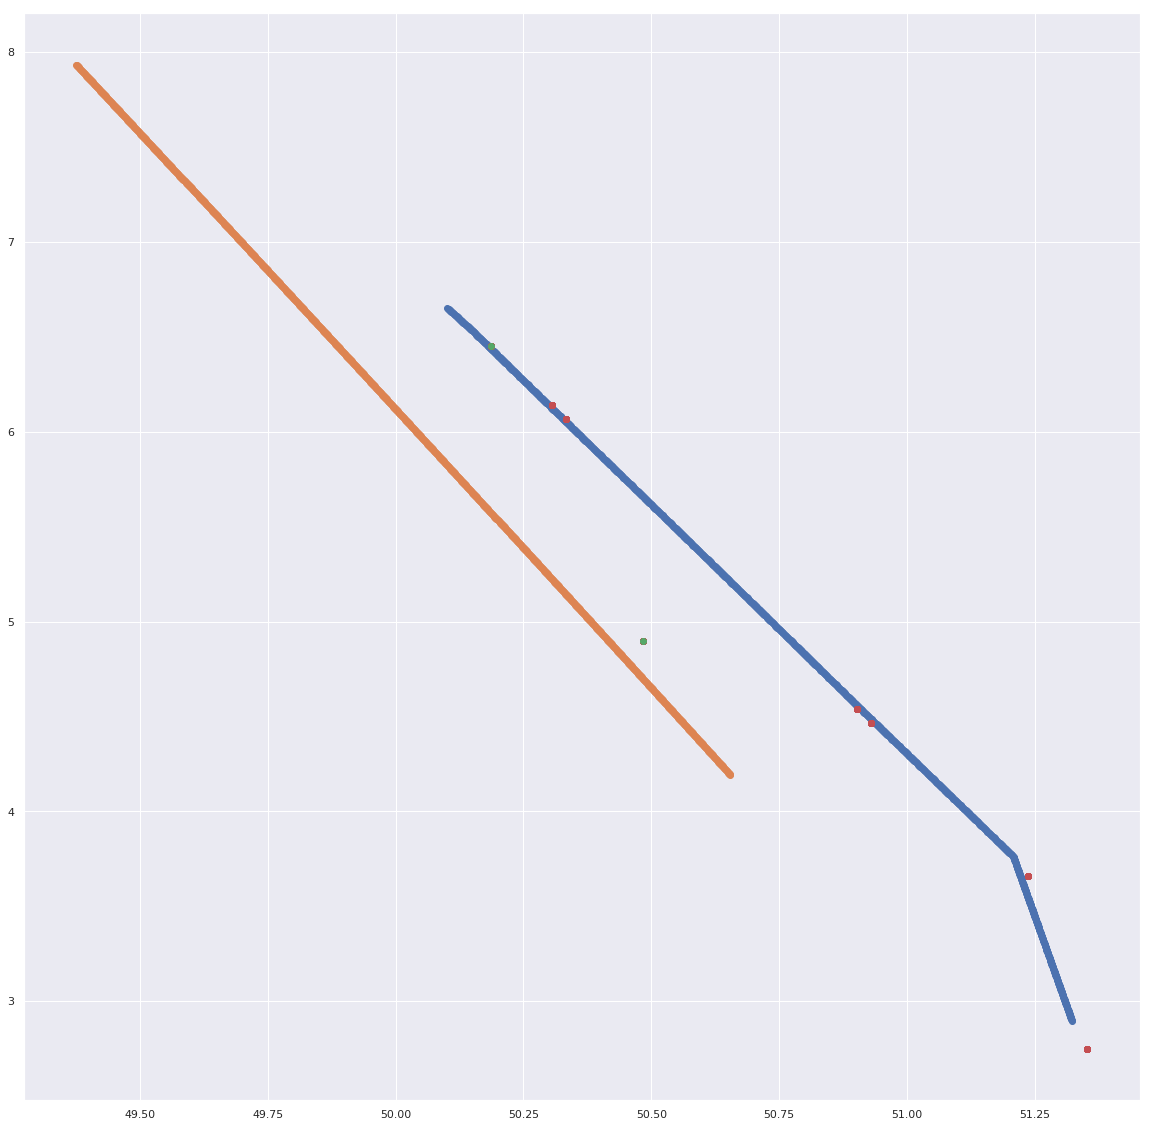

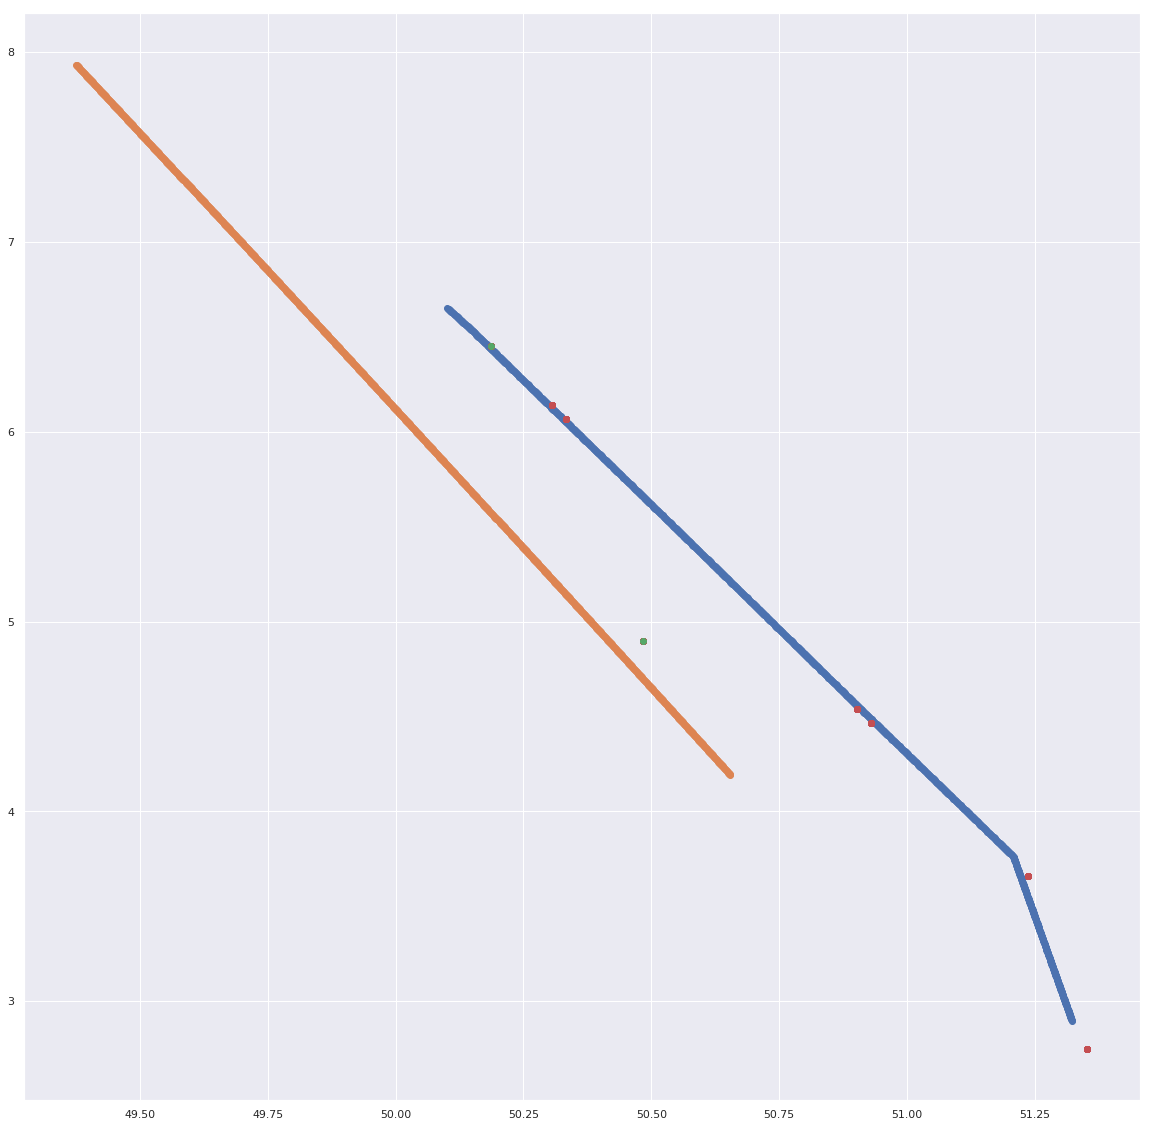

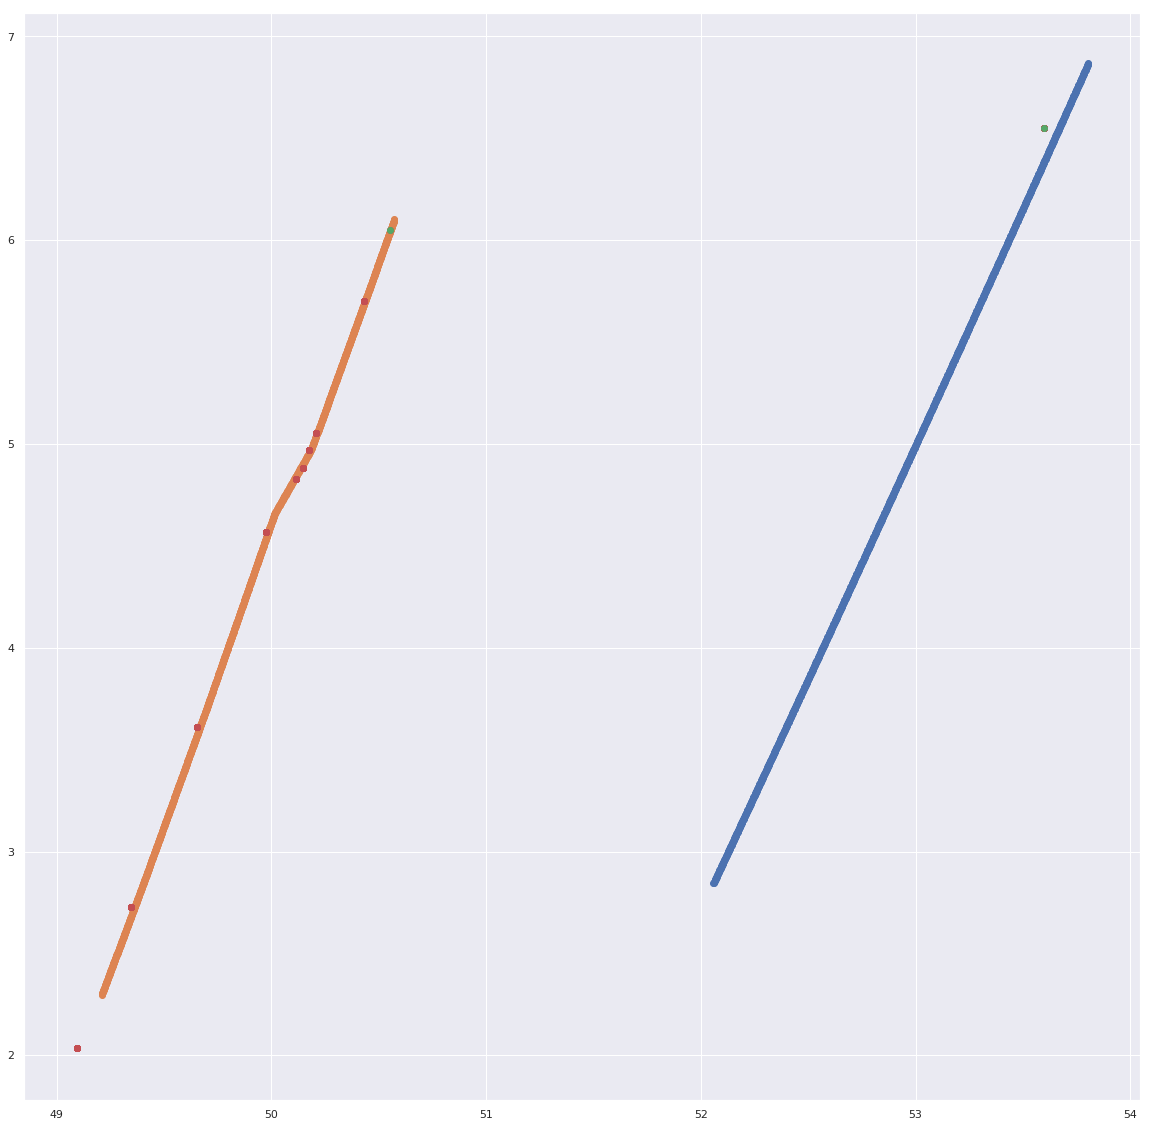

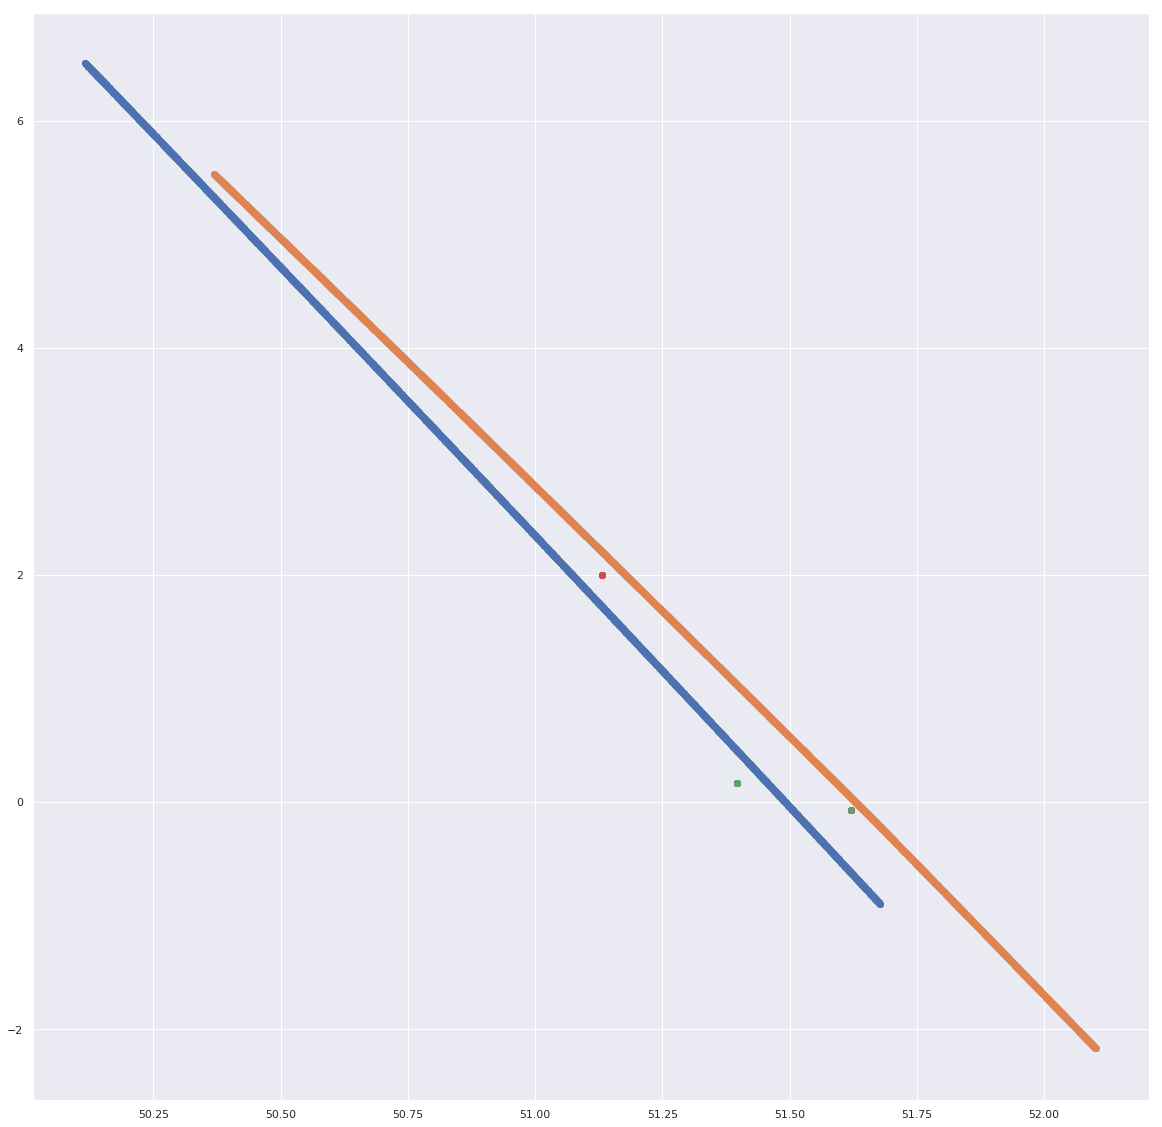

In [26]:
intent_flag = True

for i, bx in enumerate(processed_batch):
    exp_keys = ['ts_1', 'ts_2', 'lat_1', 'lon_1', 'lat_2', 'lon_2', 'hdg_1',
                'hdg_2', 'hdg_e_1', 'hdg_e_2', 'spd_1', 'spd_2', 'spd_e_1',
                'spd_e_2']

    if intent_flag:
        exp_keys.extend(['wp_seg_1', 'wp_seg_2'])

    ttc_res = []

    _pct_dict = {}
    pcti = None

    confl_count = 0
    non_confl_count = 0

    for bi in bx:

        ttc_res_i = []
        b = {}

        for k in exp_keys:
            try:
                b[k] = bi[k]
            except Exception as e:
                print(e)
                print('Not all keys present in flight dictionary')
                continue

        confl_flag = []

        for i in range(len(b['ts_1'])):
            confl_flag.append(confl_check(b['lat_1'][i], b['lon_1'][i],
                                          b['lat_2'][i], b['lon_2'][i]))

        confl_ix = np.where(np.array(confl_flag) > 0)[0]

        if len(confl_ix) > 0:
            confl_i = confl_ix[0]
            confl_ts = b['ts_1'][confl_i]

        else:
            confl_ts = None

        if confl_ts:
            print('conflict')
            tmax = confl_ts
            confl_count = confl_count + 1
        else:
            tmax = b['ts_1'][-1]
            non_confl_count = non_confl_count + 1
            

            for i, t in enumerate(b['ts_1']):

                wp_list_1 = [(wp[2][2], wp[2][3]) for wp in b['wp_seg_1'][i:]]
                wp_list_2 = [(wp[2][2], wp[2][3]) for wp in b['wp_seg_2'][i:]]

                if not wp_list_1:
                    wp_list_1 = [(b['wp_seg_1'][-1][2][2],
                                  b['wp_seg_1'][-1][2][3])]
                if not wp_list_2:
                    wp_list_2 = [(b['wp_seg_2'][-1][2][2],
                                  b['wp_seg_2'][-1][2][3])]

                if t > tmax:
                    break

                if confl_ts:
                    ttc_act_i = confl_ts - b['ts_1'][i]
                    t_la_max = int((tmax - b['ts_1'][i]) * 2)
                else:
                    ttc_act_i = np.nan
                    t_la_max = int(tmax - b['ts_1'][i])
                    
                lat_1, lon_1, lat_2, lon_2, hdg_1, \
                       hdg_2, spd_1, spd_2, _tmax, _wps_1, _wps_2 = b['lat_1'][i], b['lon_1'][i],b['lat_2'][i], \
                                                    b['lon_2'][i],b['hdg_e_1'][i],b['hdg_e_2'][i], \
                                                    b['spd_e_1'][i],b['spd_e_2'][i], t_la_max, wp_list_1, wp_list_2

                wps_seq_1 = sequentialize(_wps_1)
                wps_seq_2 = sequentialize(_wps_2)

                lat_n_1, lon_n_1, lat_n_2, lon_n_2 = lat_1, lon_1, lat_2, lon_2

                if not len(wps_seq_1) < 2:
                    wp1_curr_iter = iter(wps_seq_1)
                    wp1_next_iter = iter(wps_seq_1[1:])
                    _wp1_curr = next(wp1_curr_iter, wps_seq_1[-2])
                    _wp1_next = next(wp1_next_iter, wps_seq_1[-1])

                else:
                    wp1_curr_iter, wp1_next_iter, _wp1_curr, _wp1_next = \
                        None, None, None, None

                if not len(wps_seq_2) < 2:
                    wp2_curr_iter = iter(wps_seq_2)
                    wp2_next_iter = iter(wps_seq_2[1:])
                    _wp2_curr = next(wp2_curr_iter, wps_seq_2[-2])
                    _wp2_next = next(wp2_next_iter, wps_seq_2[-1])

                else:
                    wp2_curr_iter, wp2_next_iter, _wp2_curr, _wp2_next = \
                        None, None, None, None
                    
                lat_n1_lst = []
                lon_n1_lst = []
                wp_lat_1_lst = []
                wp_lon_1_lst = []
                lat_n2_lst = []
                lon_n2_lst = []
                wp_lat_2_lst = []
                wp_lon_2_lst = []

                for t in range(1, _tmax):

                    if t == 1:
                        lat_n_1, lon_n_1 = get_next_crd(lat_1, lon_1, hdg_1, spd_1)
                        lat_n_2, lon_n_2 = get_next_crd(lat_2, lon_2, hdg_2, spd_2)

                    else:
                        lat_n_1, lon_n_1 = get_next_crd(lat_n_1, lon_n_1, hdg_1, spd_1)
                        lat_n_2, lon_n_2 = get_next_crd(lat_n_2, lon_n_2, hdg_2, spd_2)

                    di = calc_coord_dst((lat_n_1, lon_n_1), (lat_n_2, lon_n_2))
                    
                    lat_n1_lst.append(lat_n_1)
                    lon_n1_lst.append(lon_n_1)
                    wp_lat_1_lst.append(_wp1_curr[0])
                    wp_lon_1_lst.append(_wp1_curr[1])
                    lat_n2_lst.append(lat_n_2)
                    lon_n2_lst.append(lon_n_2)
                    wp_lat_2_lst.append(_wp2_curr[0])
                    wp_lon_2_lst.append(_wp2_curr[1])

                    if di < ipz_range:
                        break

                    if not len(wps_seq_1) < 2:
                        _hdiff1 = hdg_diff_next_wp(lat_n_1, lon_n_1,
                                                   _wp1_curr, _wp1_next)
                        dst_currwp_1 = calc_coord_dst((lat_n_1, lon_n_1), _wp1_curr)

                        if abs(_hdiff1) < 4 and dst_currwp_1 < 8000:
                            hdg_1 = calc_compass_bearing(_wp1_curr, _wp1_next)
                            _wp1_curr = next(wp1_curr_iter, sequentialize(_wps_1)[-2])
                            _wp1_next = next(wp1_next_iter, sequentialize(_wps_1)[-1])
                            

                    if not len(wps_seq_2) < 2:
                        _hdiff2 = hdg_diff_next_wp(lat_n_2, lon_n_2,
                                                   _wp2_curr, _wp2_next)

                        dst_currwp_2 = calc_coord_dst((lat_n_2, lon_n_2), _wp2_curr)

                        if abs(_hdiff2) < 4 and dst_currwp_2 < 8000:
                            
                            hdg_2 = calc_compass_bearing(_wp2_curr, _wp2_next)
                            _wp2_curr = next(wp2_curr_iter, sequentialize(_wps_2)[-2])
                            _wp2_next = next(wp2_next_iter, sequentialize(_wps_2)[-1])
                            
                            
                plt.figure(figsize=(20,20))    
                plt.scatter(lat_n1_lst,lon_n1_lst)
                plt.scatter(wp_lat_1_lst,wp_lon_1_lst, c='r')
                plt.scatter(wp_lat_1_lst[0],wp_lon_1_lst[0], c='g')
                plt.scatter(lat_n2_lst,lon_n2_lst)
                plt.scatter(wp_lat_2_lst,wp_lon_2_lst, c='r')
                plt.scatter(wp_lat_2_lst[0],wp_lon_2_lst[0], c='g')
                plt.show()
                break